## The Bose-Hubbard model: Ground state properties

In [1]:
using QuantumOptics
using Plots
using Arpack
using ArnoldiMethod
using DelimitedFiles
using LaTeXStrings
using LinearAlgebra
using Statistics
pyplot()

Plots.PyPlotBackend()

### Set up the basis
We start by setting up the basis. We have `Nparticles` living on `Nsites`, and we use the QuantumOptics function `NLevelBasis()` to account for our sites. Each site is one level, which can be occupied by as many particles as we want (since we're dealing with bosons). For the basis size this is a little troublesome, since it leads to a large number of basis states. 

In [2]:
Nsites = 6                              # Actual number of physical sites is half this, we encode particle types at different sites
Nparticles = Nsites                     # To define the rotated state we initially need double the number of particles
a = NLevelBasis(Nsites)
a_mb = ManyBodyBasis(a, bosonstates(a, Nparticles))

ManyBody(onebodybasis=NLevel(N=6), states:462)

The many-body basis is spanned by the different occupations on every site. We can inspect the occupation numbers:

In [3]:
a_mb.occupations[1:4]

4-element Array{Array{Int64,1},1}:
 [6, 0, 0, 0, 0, 0]
 [5, 1, 0, 0, 0, 0]
 [5, 0, 1, 0, 0, 0]
 [5, 0, 0, 1, 0, 0]

### Set up the Hamiltonian

The Hamiltonian contains two terms, a tunneling term, and an on-site interaction term, respectively. If we express all energies in units of the tunneling rate $t$ the only free parameter is the on-site interaction $U$:
$$
    \mathcal{H} = -\sum_{\langle i,j \rangle} \hat{a}^\dagger_i \hat{a}_j + \frac{U}{2} \sum_i \hat{n}_i \left( \hat{n}_i - 1 \right)
$$
How do we convert this into a Hamiltonian we can solve numerically? In principle, we can define the creation and annihilation operators using the `create()` and `destroy()` functions QuantumOptics gives us, but constructing those involves the full many-body basis, while these are only single-particle operators. In some cases we found it numerically favorable to first define single-particle tunneling operators using the `transition()` function, which describes a transition from one level (i.e. site) to another. This single-particle operator can be converted to act on the many-body basis using the `manybodyoperator()` function.

For adding the on-site term we just use the `number()` functions. Note that all of these operators are nothing but fancy matrices, packaged in an efficient way and tagged with some information such as which basis they act on. This prevents one from accidentally using a Hamiltonian matrix and state vector belonging to different bases.

In [4]:
single_tunnel = [transition(a, i, i + 1) for i in 1 : (Nsites - 1)]
single_tunnel = [dagger.(single_tunnel); single_tunnel]
total_tunnel_s = sum([manybodyoperator(a_mb, t) for t in single_tunnel]);
onsite_interaction = sum( [ number(a_mb, i) * (number(a_mb, i) - identityoperator(a_mb)) for i in 1:Nsites ] );

Define the Hamiltonian with all energies in units of $t$, the tunneling matrix element.

In [5]:
H(t) = - t * total_tunnel_s + 1/2 * onsite_interaction

H (generic function with 1 method)

### Find the ground state

To find the ground state we use a partial Schur decomposition, which is faster than the default eigensolver supplied by QuantumOptics.

In [6]:
function getGS(t)
    decomp, history = partialschur(H(t).data, nev=2, tol=1e-6, which=SR());
    λ, ϕ = partialeigen(decomp)
    gs = Ket(a_mb, ϕ[:, 1])
end

getGS (generic function with 1 method)

One hallmark of the Mott-insulating state is that the number fluctuations disappear as we increase the lattice depth. We can calculate these by evaluating the expectation values for the operators $\hat{n_i}$ and $\hat{n_i}^2$, and averaging them over all sites.

In [7]:
n_exp(ψ) = mean( real.( [expect(number(a_mb, i), ψ) for i in 1:Nsites ] ) )
Δn(ψ) = sqrt.( mean(real.( [expect(number(a_mb, i)^2, ψ) - expect(number(a_mb, i), ψ)^2 for i in 1:Nsites ] )) )
getΔn(t, U) = Δn(getGS(t/U))

getΔn (generic function with 1 method)

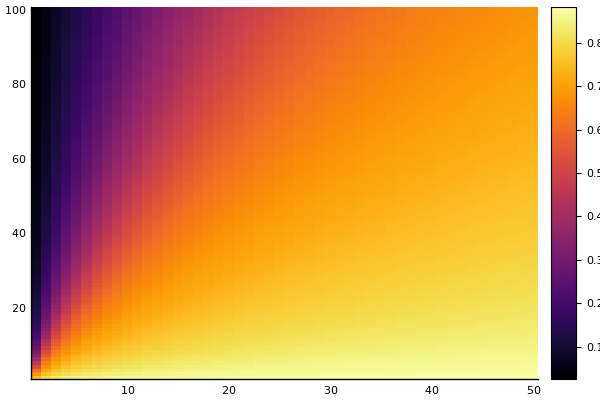

In [11]:
Us = [1:1:100;]
ts = [1:1:50;]
X = repeat(reshape(ts, 1, :), length(Us), 1)
Y = repeat(Us, 1, length(ts))

nvars = map(getΔn, X, Y)
heatmap(ts, Us, nvars)

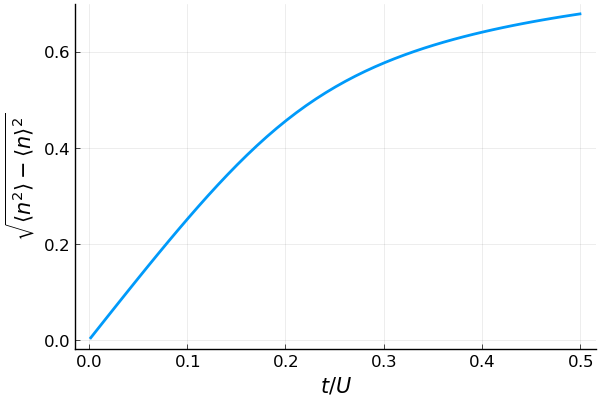

In [59]:
ts = 0.001:0.01:0.51
dat = [Δn( getGS(t) ) for t in ts];

plot(ts, dat,
    label = "test",
    linewidth = 2,
    xlabel = L"t/U",
    ylabel = L"\sqrt{\langle n^2 \rangle - \langle n \rangle^2}",
    xguidefont = font(15),
    yguidefont = font(15),
    tickfont = font(12),
    leg = false)

In [60]:
open("var_n_vs_t.csv", "w") do f
    write(f, string("u,stdn\n"))
    for i in 1:length(ts)
        write( f, string(ts[i], ",", dat[i], "\n") )
    end
end

We can also look at the behavior on every site individually:

In [48]:
Δn_ps(ψ) = [sqrt.( real( expect(number(a_mb, i)^2, ψ) - expect(number(a_mb, i), ψ)^2 ) ) for i in 1:Nsites ]

Δn_ps (generic function with 1 method)

In [51]:
ts = 0.001:0.01:0.5
dat = [Δn_ps( getGS(t) ) for t in ts];

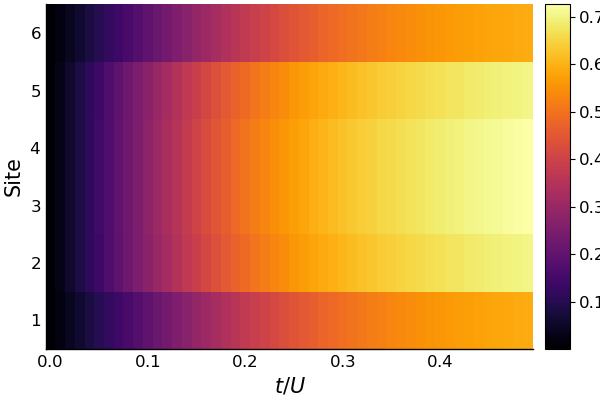

In [52]:
heatmap(ts, 1:Nsites, hcat(dat...),
    xlabel = L"t/U",
    ylabel = "Site",
    xguidefont = font(15),
    yguidefont = font(15),
    tickfont = font(12))

### Export stuff

In [53]:
using JSON

In [54]:
function expectSitePop(site, pop)
    return SparseOperator(a_mb, number(a_mb, site).data .== pop)
end

function sitePops(state, site)
    pops = abs.([expect(expectSitePop(site, p), state) for p in 1:Nparticles]).^2
    prepend!(pops, 1 - sum(pops))
    return round.(pops, digits = 3)
end

sitePops (generic function with 1 method)

In [56]:
function generateOutput(t)
    state = getGS(t)
    jsonstring = "{ \"t/U\": $t, \"sitepops\": ["
    for site_i = 1:Nsites
        pop = sitePops(state, site_i)
        jsonstring = string(jsonstring, " { \"i\" : $site_i, \"pops\" : $pop },")
    end
    jsonstring = string(jsonstring[1:end-1], "]}")
    return jsonstring
end

output_json = "{ \"data\" : ["
for t = [0.001:0.01:0.5;]
    output_json = string(output_json, generateOutput(t), ",")
end

output_json = string(output_json[1:end-1], "]}");

In [58]:
open("occupation_data.json","w") do f
  JSON.print(f, JSON.parse(output_json))
end